In [1]:
!unzip -qo -d /home/aistudio/data/data171948/ /home/aistudio/data/data171948/dog2cat.zip

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


data/data171948
data/data171948/dog2cat data/data171948/dog2cat/trainA.txt
data/data171948/dog2cat data/data171948/dog2cat/trainB.txt
读取数据的形状： (1, 3, 112, 112)
A组照片的形状： (112, 112, 3)


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


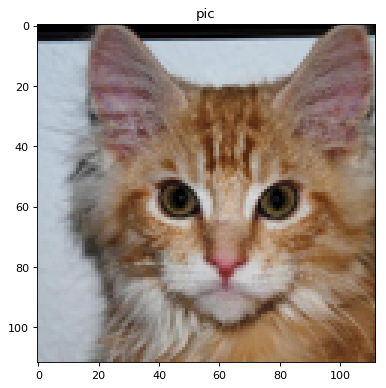

In [2]:
from data_reader import data_reader
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class CFG():
    def __init__(self):
        self.data_dir = 'data/data171948'
        self.shuffle = True
        self.dataset = 'dog2cat'
        self.model_net = 'CycleGAN'
        #self.train_list = 'data/data10830/cityscapes/pix2pix_train_list'
        self.batch_size = 1
        self.drop_last = False
        self.run_test = False
        self.load_size = 128
        self.crop_size = 112
        self.crop_type = 'Random'

cfg = CFG()
print(cfg.data_dir)

reader = data_reader(cfg)
def show_reader_data(reader):
    train_reader_a, train_reader_b, test_reader_a, test_reader_b, batch_num = reader.make_data()
    data = next(train_reader_b())
    data = np.array(data)
    # print(data.shape)
    # data = np.array(data).transpose((1, 0, 2, 3, 4))
    print('读取数据的形状：', data.shape)
    img1 = (data[0].transpose((1, 2, 0)) + 1) * 0.5
    print('A组照片的形状：', img1.shape)
    plt.figure(figsize=(12, 8), dpi=80)
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title('pic')
    plt.xticks = ([])
    plt.yticks = ([])

    return data[0]

def show_pics(pics, heatmap=np.zeros((1, 1))):
    plt.figure(figsize=(4 * len(pics), 4), dpi=80)
    for i in range(len(pics)):
        pics[i] = (pics[i][0].transpose((1,2,0)) + 1) / 2
        plt.subplot(1, len(pics), i + 1)
        plt.imshow(pics[i])
        # plt.xticks([])
        # plt.yticks([])

data = show_reader_data(reader)

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import paddle
import paddle.nn as nn 
import paddle.nn.functional as F
import paddle.vision.transforms as TF
from paddle.nn.initializer import Assign, Normal, Constant
from paddle.vision.models import vgg19
import random
import cv2

In [4]:
def get_mean_std(X, epsilon=1e-5, axis=[2,3]):
    axes = axis
    mean = paddle.mean(X, axis=axes, keepdim=True)
    standard_deviation = paddle.std(X, axis=axes, keepdim=True)
    standard_deviation = paddle.sqrt(standard_deviation + epsilon)
    return mean,standard_deviation

class AdaptiveInstanceNorm2d(nn.Layer):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(AdaptiveInstanceNorm2d, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        self.weight = None
        self.bias = None

    def forward(self, x):
        assert self.weight is not None and self.bias is not None, "No weight snd bias"

        x_mean, x_std = get_mean_std(x)
        out = self.weight * (x - x_mean) / x_std + self.bias
        return out

class LayerNorm(nn.Layer):
    def __init__(self, num_features, eps=1e-5):
        super(LayerNorm, self).__init__()
        self.num_features = num_features
        self.eps = eps

        gamma = self.create_parameter(
                shape=([1,num_features,1,1]),
                default_initializer = Assign(paddle.uniform([1,num_features,1,1]))
            )
        self.add_parameter("gamma", gamma)
        beta = self.create_parameter(
                shape=([1,num_features,1,1]),
                default_initializer = Assign(paddle.zeros([1,num_features,1,1]))
            )
        self.add_parameter("beta", beta)

    def forward(self, x):
        mean, std = get_mean_std(x, axis=[1,2,3])

        x = self.gamma * (x - mean) / (std + self.eps) + self.beta
        return x

In [5]:
class Conv2dBlock(nn.Layer):
    def __init__(self, input_dim ,output_dim, kernel_size, stride,
                 padding=0, norm='none', activation='relu', pad_type='zero'):
        super(Conv2dBlock, self).__init__()
        self.use_bias = True
        if pad_type == 'reflect':
            self.pad = nn.Pad2D(padding, 'reflect')
        elif pad_type == 'replicate':
            self.pad = nn.Pad2D(padding, 'replicate')
        elif pad_type == 'zero':
            self.pad = nn.ZeroPad2D(padding)
        else:
            assert 0, "Unsupported padding type: {}".format(pad_type)
        
        norm_dim = output_dim
        if norm == 'bn':
            self.norm = nn.BatchNorm2D(norm_dim)
        elif norm == 'in':
            self.norm = nn.InstanceNorm2D(norm_dim)
        elif norm == 'ln':
            self.norm = LayerNorm(norm_dim)
        elif norm == 'adain':
            self.norm = AdaptiveInstanceNorm2d(norm_dim)
        elif norm == 'none' or norm == 'sn':
            self.norm = None
        else:
            assert 0, "Unsupported normalization: {}".format(norm)

        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'lrelu':
            self.activation = nn.LeakyReLU(0.2)
        elif activation == 'prelu':
            self.activation = nn.PReLU()
        elif activation == 'selu':
            self.activation = nn.SELU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'none':
            self.activation = None
        else:
            assert 0, "Unsupported activation: {}".format(activation)

        # initialize convolution
        if norm == 'sn':
            self.conv = SpectralNorm(nn.Conv2d(input_dim, output_dim, kernel_size, stride, bias=self.use_bias))
        else:
            self.conv = nn.Conv2D(input_dim, output_dim, kernel_size, stride)

    def forward(self, x):
        x = self.conv(self.pad(x))
        if self.norm:
            x = self.norm(x)
        if self.activation:
            x = self.activation(x)
        return x

class LinearBlock(nn.Layer):
    def __init__(self, input_dim, output_dim, norm='none', activation='relu'):
        super(LinearBlock, self).__init__()
        use_bias = True
        if norm == 'sn':
            self.fc = SpectralNorm(nn.Linear(input_dim, output_dim, bias=use_bias))
        else:
            self.fc = nn.Linear(input_dim, output_dim)

        norm_dim = output_dim
        if norm == 'bn':
            self.norm = nn.BatchNorm(norm_dim)
        elif norm == 'in':
            self.norm = nn.InstanceNorm1D(norm_dim)
        elif norm == 'ln':
            self.norm = nn.LayerNorm(norm_dim)
        elif norm == 'adain':
            self.norm = AdaptiveInstanceNorm2d(norm_dim)
        elif norm == 'none' or norm == 'sn':
            self.norm = None
        else:
            assert 0, "Unsupported normalization: {}".format(norm)

        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'lrelu':
            self.activation = nn.LeakyReLU(0.2)
        elif activation == 'prelu':
            self.activation = nn.PReLU()
        elif activation == 'selu':
            self.activation = nn.SELU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'none':
            self.activation = None
        else:
            assert 0, "Unsupported activation: {}".format(activation)

    def forward(self, x):
        out = self.fc(x)
        if self.norm:
            out = self.norm(out)
        if self.activation:
            out = self.activation(out)
        return out
        
class ResBlock(nn.Layer):
    def __init__(self, dim, norm='in', activation='relu', pad_type='zero'):
        super(ResBlock, self).__init__()

        model = []
        model += [Conv2dBlock(dim ,dim, 3, 1, 1, norm=norm, activation=activation, pad_type=pad_type)]
        model += [Conv2dBlock(dim ,dim, 3, 1, 1, norm=norm, activation='none', pad_type=pad_type)]
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        residual = x
        out = self.model(x)
        out += residual
        return out

In [6]:
class ResBlocks(nn.Layer):
    def __init__(self, num_blocks, dim, norm='in', activation='relu', pad_type='zero'):
        super(ResBlocks, self).__init__()
        self.model = []
        for i in range(num_blocks):
            self.model += [ResBlock(dim, norm=norm, activation=activation, pad_type=pad_type)]
        self.model = nn.Sequential(*self.model)

    def forward(self, x):
        return self.model(x)

class MLP(nn.Layer):    
    def __init__(self, input_dim, output_dim, dim, n_blk, norm='none', activ='relu'):
        super(MLP, self).__init__()
        self.model = []
        self.model += [LinearBlock(input_dim, dim, norm=norm, activation=activ)]
        for i in range(n_blk - 2):
            self.model += [LinearBlock(dim, dim, norm=norm, activation=activ)]
        self.model += [LinearBlock(dim, output_dim, norm='none', activation='none')] # no output activations
        self.model = nn.Sequential(*self.model)
    
    def forward(self, x):
        return self.model(paddle.reshape(x, [x.shape[0], -1]))


In [7]:
class StyleEncoder(nn.Layer):    
    def __init__(self, dim, style_dim):
        super(StyleEncoder, self).__init__()
        self.model = []
        self.model += [nn.AdaptiveAvgPool2D(1)] # global average pooling
        self.model += [nn.Conv2D(dim, style_dim, 1, 1, 0)]
        self.model += [nn.BatchNorm2D(style_dim)]
        self.model = nn.Sequential(*self.model)
    
    def forward(self, x):
        return self.model(x)


class ContentEncoder(nn.Layer):
    def __init__(self, n_res, dim, norm, activ, pad_type):
        super(ContentEncoder, self).__init__()
        self.model = []
        # residual blocks
        self.model += [ResBlocks(n_res, dim, norm=norm, activation=activ, pad_type=pad_type)]
        self.model = nn.Sequential(*self.model)
        self.output_dim = dim

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Layer):
    def __init__(self, n_upsample, n_res, dim, output_dim, res_norm='adain', activ='relu', pad_type='zero'):
        super(Decoder, self).__init__()

        self.model = []
        self.model += [LayerNorm(dim)]
        self.model += [ResBlocks(n_res, dim, res_norm, activ, pad_type=pad_type)]
        for i in range(n_upsample):
            self.model += [nn.Upsample(scale_factor=2),
                           Conv2dBlock(dim, dim // 2, 5, 1, 2, norm='ln', activation=activ, pad_type=pad_type)]
            dim //= 2
        self.model += [Conv2dBlock(dim, output_dim, 7, 1, 3, norm='none', activation='tanh', pad_type=pad_type)]
        self.model = nn.Sequential(*self.model)

    def forward(self, x):
        return self.model(x)

class Disc(nn.Layer):

    def __init__(self, channel=64):
        super(Disc, self).__init__()
        self.conv1 = nn.Conv2D(3,channel,4,2,1,bias_attr=True,weight_attr=nn.initializer.Normal(mean=0, std=0.02))
        self.n1    = nn.InstanceNorm2D(channel)
        self.conv2 = nn.Conv2D(channel,channel*2,4,2,1,bias_attr=True,weight_attr=nn.initializer.Normal(mean=0, std=0.02))
        self.n2    = nn.InstanceNorm2D(channel*2)
        self.conv3 = nn.Conv2D(channel*2,channel*4,4,2,1,bias_attr=True,weight_attr=nn.initializer.Normal(mean=0, std=0.02))
        self.n3    = nn.InstanceNorm2D(channel*4)
        self.conv4 = nn.Conv2D(channel*4,1,4,padding=1,bias_attr=True,weight_attr=nn.initializer.Normal(mean=0, std=0.02))
     
    def forward(self, x):
        x = self.conv1(x)
        x = self.n1(x)
        x = F.leaky_relu(x,negative_slope=0.2)
        x = self.conv2(x)
        x = self.n2(x)
        x = F.leaky_relu(x,negative_slope=0.2)
        x = self.conv3(x)
        x = self.n3(x)
        x = F.leaky_relu(x,negative_slope=0.2)
        x = self.conv4(x)
        return x

In [8]:
class ACE(nn.Layer):
    def __init__(self, input_dim, params):
        super(ACE, self).__init__()

        dim = params['dim']
        style_dim = params['style_dim']
        n_res = params['n_res']
        activ = params['activ']
        pad_type = params['pad_type']
        mlp_dim = params['mlp_dim']
        self.n_downsample = params['n_downsample']
        self.n_upsample = params['n_upsample']
        self.style_dim = style_dim
        self.sim_loss = nn.CosineSimilarity()

        encoder = vgg19(pretrained = True)
            
        enc_layers = list(encoder.children())
        self.enc_1 = nn.Sequential(enc_layers[0][:4])
        self.enc_2 = nn.Sequential(enc_layers[0][4:9])
        self.enc_3 = nn.Sequential(enc_layers[0][9:18])
        self.enc_4 = nn.Sequential(enc_layers[0][18:27])
        for name in ['enc_1', 'enc_2', 'enc_3', 'enc_4']:
            for param in getattr(self, name).parameters():
                param.stop_gradient = True
        
        style_code = self.create_parameter(
            shape=(1, style_dim, 1, 1),
            default_initializer = Assign(paddle.randn([1, style_dim, 1, 1]))
        )
        self.add_parameter("style_code", style_code)
    
        self.enc_style = StyleEncoder(dim, style_dim)
        self.enc_content = ContentEncoder(n_res, dim, 'bn', activ, pad_type)
        self.dec = Decoder(self.n_upsample, n_res, self.enc_content.output_dim, input_dim, res_norm='adain', activ=activ, pad_type=pad_type)
        self.mlp = MLP(style_dim, self.get_num_adain_params(self.dec), mlp_dim, 3, norm='none', activ=activ)
        self.pred = nn.Sequential(
            nn.Conv2D(dim, dim//2, 1, 1, 0),
            nn.BatchNorm2D(dim//2),
            nn.ReLU(),
            nn.Conv2D(dim//2, dim, 1, 1, 0),
        )

    def ada_noise_decode(self, input):
        adain_params = paddle.randn(shape=[input.shape[0],self.get_num_adain_params(self.dec)])
        self.assign_adain_params(adain_params, self.dec)
        images = self.dec(input)
        return images

    def encode(self, input):
        for i in range(self.n_downsample+1):
            input = getattr(self, 'enc_{:d}'.format(i+1))(input)
        return input
    
    def content_encode(self, input):
        out = self.enc_content(input)
        out = self.pred(out)
        return out

    def decode(self, content, style):
        adain_params = self.mlp(style)
        self.assign_adain_params(adain_params, self.dec)
        images = self.dec(content)
        return images
    
    def simloss(self, p, z):
        z = z.detach()
        return -self.sim_loss(p, z).mean()

    def ace_simloss(self, p, z):
        z = z.detach()
        return paddle.mean((p-z.detach())**2)

    def forward(self, content, style):

        style_feat = self.encode(style)
        style_feat = self.enc_style(style_feat)
        
        content_feat = self.encode(content)
        content_feat = self.content_encode(content_feat)

        images_recon = self.decode(content_feat, style_feat)

        return images_recon

    def assign_adain_params(self, adain_params, model):
        for m in model.sublayers():
            if m.__class__.__name__ == "AdaptiveInstanceNorm2d":
                mean = adain_params[:, :m.num_features]
                std = adain_params[:, m.num_features:2*m.num_features]
                m.bias = mean.reshape([mean.shape[0],mean.shape[1],1,1])
                m.weight = std.reshape([std.shape[0],std.shape[1],1,1])
                if adain_params.shape[1] > 2*m.num_features:
                    adain_params = adain_params[:, 2*m.num_features:]

    def get_num_adain_params(self, model):
        num_adain_params = 0;
        for m in model.sublayers():
            if m.__class__.__name__ == "AdaptiveInstanceNorm2d":
                num_adain_params += 2*m.num_features
        return num_adain_params

# Test

In [10]:
params = {
    'n_downsample':2,
    'dim':256,
    'style_dim':8,
    'n_res':4,
    'activ':'relu',
    'pad_type':'reflect',
    'mlp_dim':256,
    'n_upsample':2,
}

ae = ACE(3, params)
ae.eval()
model_path = './output/'

ae.set_state_dict(paddle.load(model_path+'cat_100.pdparams'))
train_reader_a, train_reader_b, test_reader_a, test_reader_b, batch_num = reader.make_data()

data/data171948/dog2cat data/data171948/dog2cat/trainA.txt
data/data171948/dog2cat data/data171948/dog2cat/trainB.txt


A组照片的形状： (112, 112, 3)


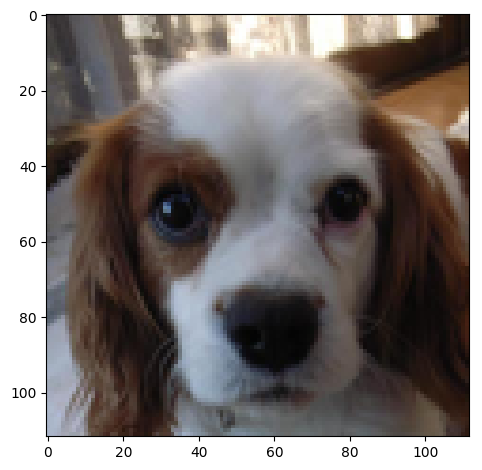

In [23]:
x1 = next(train_reader_a())
x1 = np.array(x1)
img1 = (x1[0].transpose((1, 2, 0)) + 1) * 0.5
print('A组照片的形状：', img1.shape)
plt.figure(figsize=(12, 8), dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(img1)
x1 = x1[0].reshape([1,3,112,112])
x1 = paddle.to_tensor(x1)

B组照片的形状： (112, 112, 3)


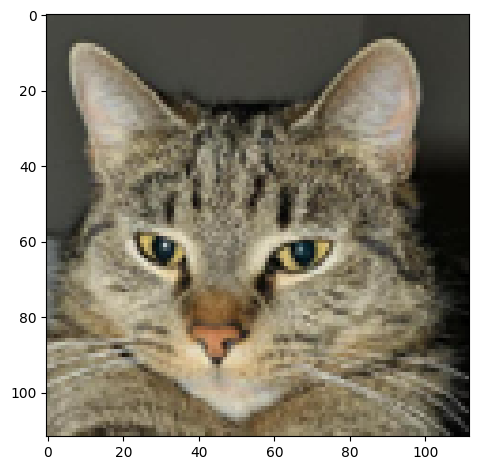

In [12]:
x2 = next(train_reader_b())
x2 = np.array(x2)
img2 = (x2[0].transpose((1, 2, 0)) + 1) * 0.5
print('B组照片的形状：', img2.shape)
plt.figure(figsize=(12, 8), dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(img2)
x2 = x2[0].reshape([1,3,112,112])
x2 = paddle.to_tensor(x2)

读取数据的形状： (3, 112, 112)
output照片的形状： (112, 112, 3)


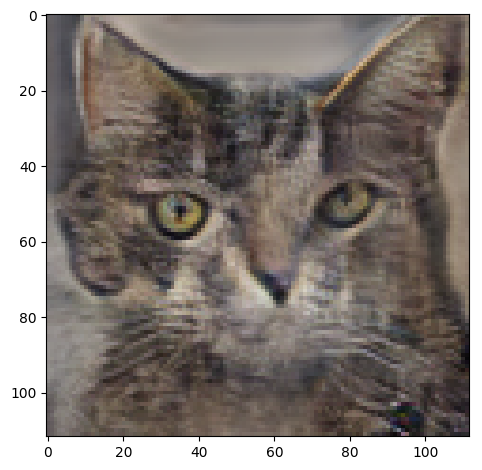

In [26]:
y = ae(x1, x2)
y = y.reshape([3,112,112]).numpy()
print('读取数据的形状：', data.shape)
img3 = (y.transpose((1, 2, 0)) + 1) * 0.5
print('output照片的形状：', img3.shape)
plt.figure(figsize=(12, 8), dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(img3)

# End of the notebook

# End